# 1. Thư viện và dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install transformers 

     |████████████████████████████████| 2.5MB 8.0MB/s 
     |████████████████████████████████| 901kB 49.6MB/s 
     |████████████████████████████████| 3.3MB 52.2MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset"

In [ ]:
train = pd.read_csv(path + "/UIT-ViCTSD/UIT-ViCTSD_train.csv", index_col=False)
dev = pd.read_csv(path + "/UIT-ViCTSD/UIT-ViCTSD_valid.csv", index_col=False)
test = pd.read_csv(path + "/UIT-ViCTSD/UIT-ViCTSD_test_text.csv", index_col=False)


#Toxicity

In [ ]:
%cd "/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-ViCTSD/Toxicity"

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-ViCTSD/Toxicity


In [ ]:
X_train = train['Comment']
y_train = train['Toxicity'].values

X_dev = dev['Comment']
y_dev = dev['Toxicity'].values

#X_test = test['Comment']
#y_test = test['Toxicity'].values

In [ ]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
num_labels = len(np.unique(y_train))

In [ ]:
# Khai bao pre-trained
bert_model = BertForSequenceClassification.from_pretrained("NlpHUST/vibert4news-base-cased", num_labels = num_labels)
bert_tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
train_encodings = bert_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = bert_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
#test_encodings = bert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
#y_test_encoding = le.transform(y_test)

In [ ]:
# Chuan bi data

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
#test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results_1',          
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

bert_trainer = Trainer(
    model=bert_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# huan luyen mo hinh

bert_trainer.train()

Step,Training Loss
500,0.255000
1000,0.084900
1500,0.032800
2000,0.014700
2500,0.015700
3000,0.014700
3500,0.007600
4000,0.019700
4500,0.010700
5000,0.010600


TrainOutput(global_step=21900, training_loss=0.012392461696514338, metrics={'train_runtime': 6335.4171, 'train_samples_per_second': 110.49, 'train_steps_per_second': 3.457, 'total_flos': 2.2454692176e+16, 'train_loss': 0.012392461696514338, 'epoch': 100.0})

#Lấy File y_Predicted

In [ ]:
X_test = test['Comment']
test['Toxicity'] = 0
y_test = test['Toxicity'].values #Gán cho y_test giá trị constant= 0 để đủ 2 cột đưa vào hàm
test_encodings = bert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)
y_test_encoding = le.transform(y_test)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
 # Du doan 
y_pred_classify = bert_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
import pandas as pd

pd.DataFrame({"Y_Prediced": y_pred}).to_csv('Bert4News_ViCTSD_Toxicity_1_1.csv', index= False)

#Đánh giá kết quả

In [ ]:
import pandas as pd
labelTest= pd.read_json("/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-ViCTSD/LabelTest.json")
labelTest.head()

,,id,comment,constructiveness,toxicity,title,topic
0,0,6252,Người ăn không hết kẻ lần chẳng ra,0,1,28 năm chịu đựng bộ ngực khổng lồ,SucKhoe
1,1,4684,Nhiều người cứ nghĩ đạp xe là văn minh. haizzzz,0,1,Cả trăm người đạp xe thể dục bịt kín đường,OtoXemay
2,2,1731,Rất văn hoá,0,0,Cô gái được bố nhắn nhủ ba từ mỗi ngày,GiaoDuc
3,3,4742,Đời ta ba mươi đời nó. Mua chiếc xe cũng chỉ p...,0,0,Các loại phụ kiện ôtô đại lý hay chào khách,OtoXemay
4,4,4521,"Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật,...",1,1,Ba người thoát chết dưới bánh xe bồn,OtoXemay


In [ ]:
# Đọc file labels predict lên
labelPred= pd.read_csv('/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-ViCTSD/Toxicity/Bert4News_ViCTSD_Toxicity_1_1.csv')
labelPred.head()

,Y_Prediced
0,1
1,0
2,0
3,0
4,1


In [ ]:
# Đánh giá:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = labelTest.toxicity
#y_pred_classify = model_lstm_cnn.predict(x_test_seq)
#y_pred = y_pred_classify.argmax(axis=-1)
y_pred = labelPred

cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_true).astype(str).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels= pd.Series(y_true).unique(), target_names=target_names))

[[ 43  67]
 [ 34 856]]
accuracy: 0.899
F1 - macro: 0.7020921390669289
Classification report in Training set
              precision    recall  f1-score   support

           1       0.56      0.39      0.46       110
           0       0.93      0.96      0.94       890

    accuracy                           0.90      1000
   macro avg       0.74      0.68      0.70      1000
weighted avg       0.89      0.90      0.89      1000



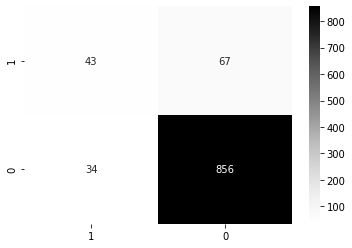

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = pd.Series(y_true).unique(),
                  columns = pd.Series(y_true).unique())

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})